In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from scipy.integrate import simps

In [2]:
Omicron_New_Cases = pd.read_csv('Omicron_wave_Jan_May.csv',parse_dates=['date'],index_col= ['date'],)
NewCases = Omicron_New_Cases['new_cases'] 

In [3]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau2 = 0.8;
psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/10; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
a = 1/3  # fixed to be 3 days 
 

theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
Fmax = 0.027; F10 = 0.0029; F20 = (0.9)*F10;
Tmax = 0.5; T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit
#Tmax = 0.022; T10 = 0.014; #T10 = 0.0013; 


In [4]:
# Fitted parameters
k1=  0.51
beta1=  0.65
beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  

In [5]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
S2_0 = 40000000 # 0.9*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S3_0 = 4365186 #0.1*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + H_0 + R_0)

In [6]:
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [7]:
t = np.linspace(0,119,119)

In [8]:
def model_eq(x,t):
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN  = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = T10 + (Tmax -T10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(B*MN)/(1+B*MN) )
    F1 = F10 + (Fmax -F10)*(alpha1*(Dtilde*MV)/(1+Dtilde*MV) + (1-alpha1)*(Btilde*MN)/(1+Btilde*MN))
    
    T2 = T20 + (Tmax -T20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*B*MN)/(1+theta*B*MN) )
    F2 = F20 + (Fmax -F20)*(alpha2*(theta*Dtilde*MV)/(1+theta*Dtilde*MV) + (1-alpha2)*(theta*Btilde*MN)/(1+theta*Btilde*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+I1+I2+H)/NN)-MV)
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    return dx

In [9]:
for i in [1,2]:
    Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
    D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
    
    if i ==1:
        D = 0 ; B = 0; Btilde =0;
        Dtilde = 0
        x = odeint(model_eq,x0,t)
        Total_cases1 = x[:,7] + x[:,8] + x[:,9] + x[:,10] + x[:,11] + x[:,12] + x[:,13]
        total_population = x[:,0] + x[:,1] + x[:,2] + x[:,3] +x[:,4] + x[:,5] + x[:,6] + x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13] + x[:,14]
        determined1 = x[:,11] + x[:,12]
        determined11 = np.divide(determined1,total_population)
        undetermined1 = x[:,7] + x[:,8] + x[:,9] + x[:,10]
        undetermined11 = np.divide(undetermined1,total_population)
        total_infected1 = determined1 + undetermined1;
        Daily_infected1 = eps*(x[:,5] + x[:,6])
        Vac2_1 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*Dtilde*x[:,16],(1+theta*Dtilde*x[:,16])) + (1-alpha2)* np.divide(theta*Btilde*x[:,17],(1+theta*Btilde*x[:,17])) )
        Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:,16],(1+D*x[:,16])) + (1-alpha1)* np.divide(B*x[:,17],(1+B*x[:,17]))) 
        Test2_1 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*x[:,16],(1+theta*D*x[:,16])) + (1-alpha2)* np.divide(theta*B*x[:,17],(1+theta*B*x[:,17])))
        In1 = np.multiply(Test1_1,(xi*x[:,7]+ x[:,9])) + np.multiply(Test2_1,(xi*x[:,8]+ x[:,10]))
        In_undetected1 = x[:,11] + x[:,12] + x[:,13]
        vacc1 = x[:,3] +x[:,4]
        Max_Infected1 = max(x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13])
        Max_Hosp_Dead1 = max (x[:,13] +x[:,15])
        Max_In1 = max(In1)
        Area1 = simps(In1, t)                              
    
    elif i ==2:
        Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
        
        D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
        
        x = odeint(model_eq,x0,t)
        Total_cases2 =  x[:,7] + x[:,8] + x[:,9] + x[:,10] + x[:,11] + x[:,12] + x[:,13]
        total_population = x[:,0] + x[:,1] + x[:,2] + x[:,3] +x[:,4] + x[:,5] + x[:,6] + x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13] + x[:,14]
        determined2 = x[:,11] + x[:,12]
        Daily_infected2 = eps*(x[:,5] + x[:,6])
        determined22 = np.divide(determined2,total_population)
        undetermined2 = x[:,7] + x[:,8] + x[:,9] + x[:,10]
        undetermined22 = np.divide(undetermined2,total_population)
        total_infected2 = determined2 + undetermined2;
        Test1_4 = T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:,16],(1+D*x[:,16])) + (1-alpha1)* np.divide(B*x[:,17],(1+B*x[:,17]))) 
        Vac1_4 = F10 + (Fmax -F10)*(alpha1* np.divide(Dtilde*x[:,16],(1+Dtilde*x[:,16])) + (1-alpha1)* np.divide(Btilde*x[:,17],(1+Btilde*x[:,17]))) 
        Test2_4 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*x[:,16],(1+theta*D*x[:,16])) + (1-alpha2)* np.divide(theta*B*x[:,17],(1+theta*B*x[:,17]))) 
        Vac2_4 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*Dtilde*x[:,16],(1+theta*Dtilde*x[:,16])) + (1-alpha2)* np.divide(theta*Btilde*x[:,17],(1+theta*Btilde*x[:,17])) ) 
        # Test1_1 = T10 + (Tmax -T10)*(np.divide(D*x[:,16],(1+D*x[:,16])))
        # Test2_1 = T20 + (Tmax -T20)*(np.divide(B*x[:,17],(1+B*x[:,17])))
        In4 = np.multiply(Test1_4,(xi*x[:,7]+ x[:,9])) + np.multiply(Test2_4,(xi*x[:,8]+ x[:,10]))
        In_undetected2 = x[:,11] + x[:,12] + x[:,13]
        vacc2 = x[:,3] +x[:,4]
        Max_Infected2 = max(x[:,7] + x[:,8] + x[:,9] + x[:,10] +x[:,11] + x[:,12] + x[:,13])
        Max_Hosp_Dead2 = max (x[:,13] +x[:,15])
        Max_In4 = max(In4)
        Max_T1 = max(Test1_4); Max_T2 = max(Test2_4); Max_V1 = max(Vac1_4);Max_V2 = max(Vac2_4);
        Final_In4 = In4[-1]
        Area4 = simps(In4, t)


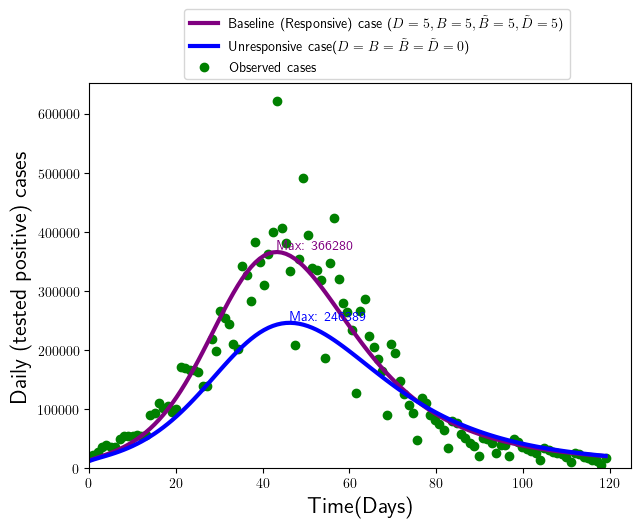

In [10]:
fig, axs = plt.subplots(figsize=(7,5))
plt.plot(t,In4,label = fr'Baseline (Responsive) case ($D ={D:.0f}, B ={B:.0f}, \tilde B ={Btilde:.0f}, \tilde D={Dtilde:.0f}$)',color = 'purple', lw =3)
plt.plot(t,In1, label = r'Unresponsive case($D = B = \tilde{B} =\tilde{D} =0$)' , color = 'blue', lw = 3)
plt.scatter(t,NewCases, label = r'Observed cases', color = 'green')
plt.text(t[np.argmax(In1)], Max_In1, f'Max: {Max_In1:.0f}', ha='left', va='bottom', color='blue')
plt.text(t[np.argmax(In4)], Max_In4, f'Max: {Max_In4:.0f}', ha='left', va='bottom', color='purple')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Time(Days)', fontsize=16)
plt.ylabel('Daily (tested positive) cases',fontsize=16)
#plt.title('(a)', loc='left')
plt.legend(bbox_to_anchor = (0.9,1.21))


# axs[1].plot(t,vacc2, lw=3, color = 'purple', label = 'Baseline case')
# axs[1].plot(t,vacc1, lw=3, color = 'blue', label = 'Unresponsive case')
# axs[1].set_xlim(left=0)
# axs[1].set_ylim(bottom=0)
# axs[1].set_xlabel('Time(Days)', fontsize=16)
# axs[1].set_ylabel('Vaccinated people',fontsize=16)

# axs[1].legend()
plt.savefig('NEWCase2_vacc_dt_T1_T2_F1_F2.png',dpi=600, bbox_inches='tight')
plt.show()
#plt.legend(bbox_to_anchor= (0.6,1.25))